# Markov Chains and Hidden Markov Models  

We will see a basic implementation of how Markov Chains works and how hidden Markov Models could be used


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline 
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from hmmlearn import hmm

Let's first create some random samples of a symbolic random variable corresponding to the weather with two values Sunny (S) and cloudy (C) and generate random weather for 365 days. The assumption in this model is that the weather of each day is indepedent of the previous days and drawn from the same probability distribution. 

stats.rv_discrete is a base class to construct specific distribution classes and instances for discrete random variables. It can also be used to construct an arbitrary distribution defined by a list of support points and corresponding probabilities.

Once distrution classes are created containing values with probability of them being picked, we can use them to pick random variables corresponding to their proabability distribution values. For example, if values = [0, 1] and probability_distribution is [0.5, 0.5]. There is a 50% chance of picking 0, 1 and we can do this simply by calling self.rv.rvs(size=no_of_samples_needed) where self.rv is the base class we created use stats.rv_discrete with values as [0, 1] and probability_distributions as [0.5, 0.5].

Incase of values being strings like ['Sunny', 'Cloudy'] we can encode them as 'Sunny' -> 0 and 'Cloudy' -> 1 and perform the above given process and then map them to 'Sunny' or 'Cloudy' since a picked value of 0 describes it is 'Sunny' and 1 indicates that is 'Cloudy'.

In [4]:
class Random_Variable: 
    
    def __init__(self, name, values, probability_distribution): 
        self.name = name 
        self.values = values 
        self.probability_distribution = probability_distribution 
        if all(type(item) is np.int64 for item in values): 
            self.type = 'numeric'
            self.rv = stats.rv_discrete(name = name, values = (values, probability_distribution))
        elif all(type(item) is str for item in values): 
            self.type = 'symbolic'
            self.rv = stats.rv_discrete(name = name, values = (np.arange(len(values)), probability_distribution))
            self.symbolic_values = values 
        else: 
            self.type = 'undefined'
            
    def sample(self,size): 
        if (self.type =='numeric'): 
            return self.rv.rvs(size=size)
        elif (self.type == 'symbolic'): 
            numeric_samples = self.rv.rvs(size=size)
            mapped_samples = [self.values[x] for x in numeric_samples]
            return mapped_samples 
        
    def probs(self): 
        return self.probability_distribution
    
    def vals(self): 
        print(self.type)
        return self.values 

We perform the process specified above and create about 365 samples of 'S' or 'C' according to their probability distribution (in this case equal). Here we are independently sampling them, i.e. there is no relation between value to be picked and the last value which was picked.

In [5]:
values = ['S', 'C']
probabilities = [0.5, 0.5]
weather = Random_Variable('weather', values, probabilities)
samples = weather.sample(365)

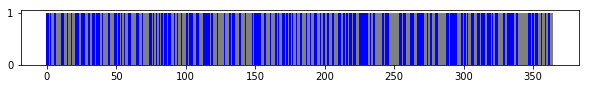

In [6]:
state2color = {} 
state2color['S'] = 'blue'
state2color['C'] = 'grey'

def plot_weather_samples(samples, state2color): 
    colors = [state2color[x] for x in samples]
    x = np.arange(0, len(colors))
    y = np.ones(len(colors))
    plt.figure(figsize=(10,1))
    plt.bar(x, y, color=colors, width=1)
    
plot_weather_samples(samples, state2color)

Now instead of independently sampling the weather random variable lets form a markov chain. 

By Markov Chain, we simply mean that picking up of a value now depends not only on their probability distribution but also on their previous state.

Here take transmat_1 for example, consider first row as state A and second row as state_B -> [[0.7, 0.3], [0.2, 0.8]], it means that if current state is A, there is 70% probability it will stay in the same state and 30% probability it will go to state 2 else if current state is B, there is 20% chance of staying in the same state and 80% chance of going to next state.

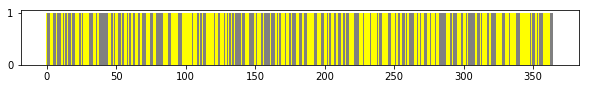

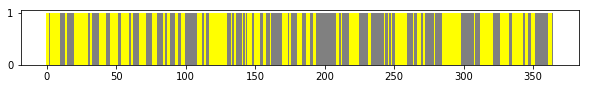

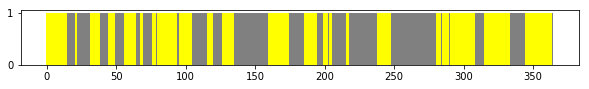

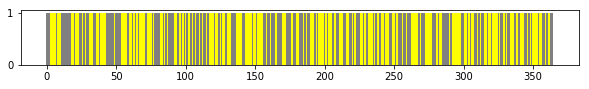

In [7]:
def markov_chain(transmat, state, state_names, samples): 
    (rows, cols) = transmat.shape 
    rvs = [] 
    values = list(np.arange(0,rows))
    
    # create random variables for each row of transition matrix 
    for r in range(rows): 
        rv = Random_Variable("row" + str(r), values, transmat[r])
        rvs.append(rv)
    
    # start from initial state and then sample the appropriate 
    # random variable based on the state following the transitions 
    states = [] 
    for n in range(samples): 
        state = rvs[state].sample(1)[0]    
        states.append(state_names[state])
    return states


# transition matrices for the Markov Chain 
transmat1 = np.array([[0.7, 0.3], 
                    [0.2, 0.8]])

transmat2 = np.array([[0.9, 0.1], 
                    [0.1, 0.9]])

transmat3 = np.array([[0.5, 0.5], 
                     [0.5, 0.5]])



# plot the iid model too

state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'
samples = weather.sample(365)

plot_weather_samples(samples, state2color)

samples1 = markov_chain(transmat1,0,['S','C'], 365)
plot_weather_samples(samples1, state2color)

samples2 = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(samples2, state2color)

samples3 = markov_chain(transmat3,0,['S','C'], 365)
plot_weather_samples(samples3, state2color)


Lets now look at how a Hidden Markov Model would work by having a Markov Chain to generate 
a sequence of states and for each state having a different emission probability. When sunny we will output red or yellow with higher probabilities and when cloudy black or blue. First we will write the code directly and then we will use the hmmlearn package. 

Now here, we use concepts explained above to predict whether next day is going to sunny or cloudy. Hidden markov modelis nothing but chain of events generated in which state from which events are picked are hidden in the sense that it depends on the previous state of the chain and the value picked in previous state of the chain

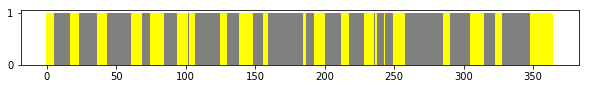

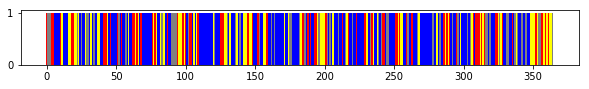

In [8]:
state2color = {} 
state2color['S'] = 'yellow'
state2color['C'] = 'grey'

samples = weather.sample(365)
states = markov_chain(transmat2,0,['S','C'], 365)
plot_weather_samples(states, state2color)

sunny_colors = Random_Variable('sunny_colors', ['y', 'r', 'b', 'g'], 
                              [0.4, 0.4, 0.1, 0.1])
cloudy_colors = Random_Variable('cloudy_colors', ['y', 'r', 'b', 'g'], 
                               [0.1, 0.1, 0.6, 0.2])

def emit_sample(state, sunny_colors, cloudy_colors): 
    if (state == 'S'): 
        sample = sunny_colors.sample(1)[0]
    else: 
        sample = cloudy_colors.sample(1)[0]
    return sample 

samples = [emit_sample(s, sunny_colors, cloudy_colors) for s in states]
state2color = {} 
state2color['y'] = 'yellow'
state2color['r'] = 'red'
state2color['b'] = 'blue'
state2color['g'] = 'grey'
plot_weather_samples(samples, state2color)





In [9]:
transmat = np.array([[0.9, 0.1], 
                    [0.1, 0.9]])

start_prob = np.array([1.0, 0.0, 0.0])

# yellow and red have high probs for sunny 
# blue and grey have high probs for cloudy 
emission_probs = np.array([[0.4, 0.4, 0.1, 0.1], 
                           [0.1, 0.1, 0.6, 0.2]])

model = hmm.MultinomialHMM(n_components=2)
model.startprob_ = start_prob 
model.transmat_ = transmat 
model.emissionprob_ = emission_probs

# sample the model - X is the observed values 
# and Z is the "hidden" states 
X, Z = model.sample(365)

state2color = {} 
state2color[0] = 'yellow'
state2color[1] = 'grey'
plot_weather_samples(Z, state2color)

samples = [item for sublist in X for item in sublist]

state2color = {} 
state2color[0] = 'yellow'
state2color[1] = 'red'
state2color[2] = 'blue'
state2color[3] = 'grey'
plot_weather_samples(samples, state2color)



ValueError: startprob_ must have length n_components